In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

In [3]:
CALLBACK = True
IMG_SIZE = 224

In [4]:
if CALLBACK:
    
    class myCallback(tf.keras.callbacks.Callback):
        def __init__(self, target_loss = 0.32, patience = 3):
            super(myCallback, self).__init__()
            self.target_loss = target_loss
            self.curr_loss = np.inf
            self.best_loss = np.inf
            self.init_patience = patience
            self.patience = patience

        def on_epoch_end(self, epoch, logs={}):
            self.curr_loss = logs.get('loss')
            if(self.curr_loss < self.target_loss):
                print("Desired Loss achieved!\n")
            if(self.curr_loss>self.best_loss):
                print("\n! Loss is not decreasing !")
                self.patience -= 1
                if (self.patience == 0):
                        print('\n\n!! Training has been stopped !!')
                        self.model.stop_training = True 
            else:
                self.best_loss = self.curr_loss
                self.patience = self.init_patience

    callbacks = myCallback()

    checkpoint_filepath = 'my_model.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)
    
    my_callback = [callbacks, model_checkpoint_callback]
    
else:
    
    my_callback = None

In [5]:
data_dir = './datasets/fruits'
apple_dir = os.path.join(data_dir, 'apple')
banana_dir = os.path.join(data_dir, 'banana')
background_dir = os.path.join(data_dir, 'background')

apple_list = os.listdir(apple_dir)
banana_list = os.listdir(banana_dir)
background_list = os.listdir(background_dir)

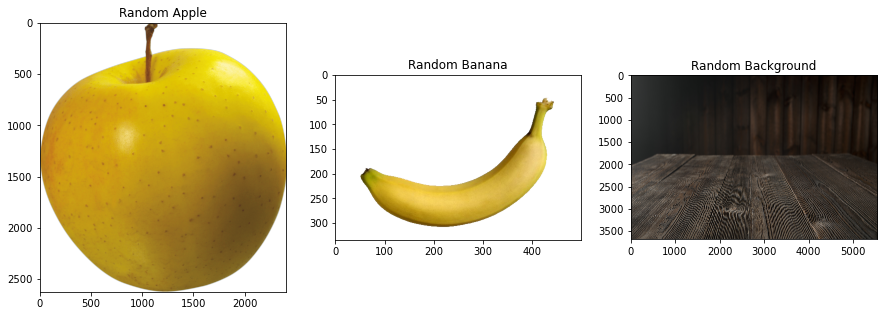

In [6]:
selected_apple = np.random.choice(apple_list)
selected_banana = np.random.choice(banana_list)
selected_background = np.random.choice(background_list)

plt.figure(figsize=(15, 5))

img = tf.io.read_file(os.path.join(apple_dir,selected_apple))
img = tf.image.decode_jpeg(img, channels=4)
img = tf.cast(img, tf.float32) / 255.0
plt.subplot(1, 3, 1)
plt.title('Random Apple')
plt.imshow(img)

img = tf.io.read_file(os.path.join(banana_dir,selected_banana))
img = tf.image.decode_jpeg(img, channels=4)
img = tf.cast(img, tf.float32) / 255.0
plt.subplot(1, 3, 2)
plt.title('Random Banana')
plt.imshow(img)

img = tf.io.read_file(os.path.join(background_dir,selected_background))
img = tf.image.decode_jpeg(img, channels=3)
img = tf.cast(img, tf.float32) / 255.0
plt.subplot(1, 3, 3)
plt.title('Random Background')
plt.imshow(img)

plt.show()

Background image shape:  (3688, 5532, 3)
object size:  (997, 997, 4)


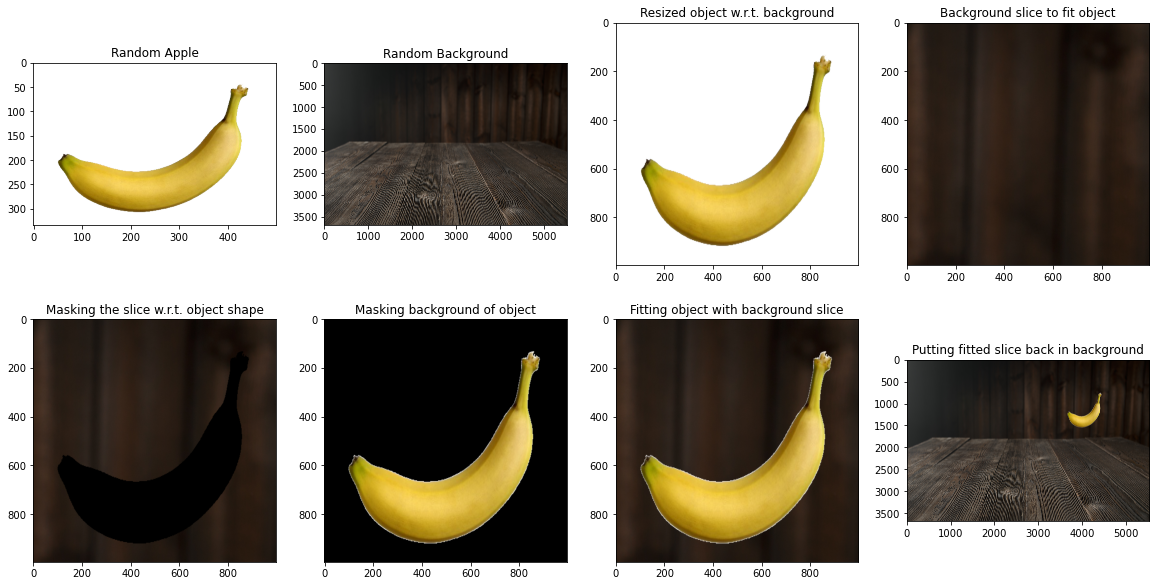

In [7]:
plt.figure(figsize=(20, 10))

choice = np.random.choice([os.path.join(apple_dir,np.random.choice(apple_list)),
                           os.path.join(banana_dir,np.random.choice(banana_list)),
                           None])
if choice:
    obj = tf.io.read_file(os.path.join(choice))
    obj = tf.image.decode_jpeg(obj, channels=4)
    obj = tf.cast(obj, tf.float32) / 255.0
    plt.subplot(2, 4, 1)
    plt.title('Random Apple')
    plt.imshow(obj)
    
    bg = tf.io.read_file(os.path.join(background_dir,np.random.choice(background_list)))
    bg = tf.image.decode_jpeg(bg, channels=3)
    bg = tf.cast(bg, tf.float32) / 255.0
    plt.subplot(2, 4, 2)
    plt.title('Random Background')
    plt.imshow(bg)
    print('Background image shape: ', bg.shape)
    
    max_size = min(bg.shape[0], bg.shape[1])
    min_size = int(max_size/5)
    obj_size = tf.random.uniform((), min_size , max_size, dtype=tf.int32)    
    
    resized_obj = tf.image.resize(obj, (obj_size, obj_size))
    print('object size: ', resized_obj.shape)
    plt.subplot(2, 4, 3)
    plt.title('Resized object w.r.t. background')
    plt.imshow(resized_obj)
    
    row0 = tf.random.uniform((), 0 , bg.shape[0] - obj_size, dtype=tf.int32)
    col0 = tf.random.uniform((), 0 , bg.shape[1] - obj_size, dtype=tf.int32)
    row1 = row0 + obj_size
    col1 = col0 + obj_size
    
    bg_slice1 = bg[row0:row1,col0:col1,:] # where we want to place `obj`
    plt.subplot(2, 4, 4)
    plt.title('Background slice to fit object')
    plt.imshow(bg_slice1)

    mask = (resized_obj[:,:,3] == 0) # find where the pokemon is 0
    mask = tf.cast(mask, tf.float32)

    bg_slice2 = np.expand_dims(mask, -1) * bg_slice1 # (h,w,1) x (h,w,3)
    plt.subplot(2, 4, 5)
    plt.title('Masking the slice w.r.t. object shape')
    plt.imshow(bg_slice2)

    obj_slice = np.expand_dims(np.logical_not(mask), -1)*resized_obj[:,:,:3] # "add" the pokemon to the slice
    plt.subplot(2, 4, 6)
    plt.title('Masking background of object')
    plt.imshow(obj_slice)

    bg_slice = bg_slice2 + obj_slice
    plt.subplot(2, 4, 7)
    plt.title('Fitting object with background slice')
    plt.imshow(bg_slice)

    bg = bg.numpy()
    bg[row0:row1,col0:col1,:] = bg_slice
    plt.subplot(2, 4, 8)
    plt.title('Putting fitted slice back in background')
    plt.imshow(bg)
    
else:
    bg = tf.io.read_file(os.path.join(background_dir,np.random.choice(background_list)))
    bg = tf.image.decode_jpeg(bg, channels=3)
    bg = tf.cast(bg, tf.float32) / 255.0
    bg = bg.numpy()
    plt.imshow(bg)
     
del bg

In [8]:
def load_image(path, channels = 3):
    bg = tf.io.read_file(path)
    bg = tf.image.decode_jpeg(bg, channels=channels)
    return tf.cast(bg, tf.float32) / 255.0

backgrounds = [load_image(os.path.join(background_dir, i)) for i in background_list]

apples = [load_image(os.path.join(apple_dir, i), 4) for i in apple_list]
bananas = [load_image(os.path.join(banana_dir, i), 4) for i in banana_list]

In [9]:
# @tf.function
def resize_crop_img(img):
    img = tf.image.resize(img, (500, 500), preserve_aspect_ratio=True)
    return tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))

In [10]:
len_apples = len(apples)
len_bananas = len(bananas)
len_backgrounds = len(backgrounds)

In [11]:
def scene_generator(batch_size=8):
    # generate image and targets
    while True:
        # Each epoch will have 50 batches
        for _ in range(50):
            X = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
            Y = np.zeros((batch_size, 7))
            for i in range(batch_size):

                random_bg = tf.random.uniform((), 0 , len_backgrounds, dtype=tf.int32)
                bg = backgrounds[random_bg]
                bg = resize_crop_img(bg)
                bg = bg.numpy()

                c_index = np.random.choice(list(range(3)))
                if c_index:
                    Y[i, 6] = 1
                    if c_index == 1:
                        index = tf.random.uniform((), 0 , len_apples, dtype=tf.int32)
                        obj = apples[index]
                        Y[i,4] = 1
                    else:
                        index = tf.random.uniform((), 0 , len_bananas, dtype=tf.int32)
                        obj = bananas[index]
                        Y[i,5] = 1

                    max_size = IMG_SIZE
                    min_size = int(max_size/5)
                    obj_size = tf.random.uniform((), min_size , max_size, dtype=tf.int32)
                    resized_obj = tf.image.resize(obj, (obj_size, obj_size))

                    row0 = tf.random.uniform((), 0 , IMG_SIZE - obj_size, dtype=tf.int32)
                    col0 = tf.random.uniform((), 0 , IMG_SIZE - obj_size, dtype=tf.int32)
                    row1 = row0 + obj_size
                    col1 = col0 + obj_size

                    bg_slice = bg[row0:row1,col0:col1,:]
                    mask = (resized_obj[:,:,3] == 0)
                    mask = tf.cast(mask, tf.float32)

                    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
                    obj_slice = np.expand_dims(np.logical_not(mask), -1)*resized_obj[:,:,:3]
                    bg_slice = bg_slice + obj_slice
                    bg[row0:row1,col0:col1,:] = bg_slice

                    # location
                    Y[i,0] = row0/bg.shape[0]
                    Y[i,1] = col0/bg.shape[1]
                    Y[i,2] = (row1 - row0)/bg.shape[0]
                    Y[i,3] = (col1 - col0)/bg.shape[1]

                X[i] = bg
            yield X, Y

In [12]:
xx = None
yy = None
for x, y in scene_generator():
    xx, yy = x, y
    break

In [13]:
def custom_loss(y_true, y_pred):
    # target is a 7-tuple
    # (row, col, depth, width, class1, class2, object_appeared)

    bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # location
    cce = categorical_crossentropy(y_true[:, 4: -1], y_pred[:, 4: -1]) # object class
    bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # object appeared

    return bce * y_true[:, -1] + cce * y_true[:, -1] + bce2

In [14]:
def make_model():
    vgg = tf.keras.applications.VGG16(
        input_shape=[IMG_SIZE, IMG_SIZE, 3],
        include_top=False,
        weights='imagenet')
    x = Flatten()(vgg.output)
    x1 = Dense(4, activation='sigmoid')(x) # location
    x2 = Dense(2, activation='softmax')(x) # object class
    x3 = Dense(1, activation='sigmoid')(x) # object appeared
    x = Concatenate()([x1, x2, x3])
    model = Model(vgg.input, x)
    model.compile(loss=custom_loss,
                  optimizer=Adam(lr=0.0001))
    return model

In [15]:
model = make_model()
history = model.fit(
    scene_generator(),
    steps_per_epoch=50,
    epochs=50,
    verbose = 1,
    callbacks=my_callback
)

Epoch 1/50
50/50 [==============================] - 19s 198ms/step - loss: 1.0708
Epoch 2/50
50/50 [==============================] - 10s 200ms/step - loss: 0.4691
Epoch 3/50
50/50 [==============================] - 10s 201ms/step - loss: 0.3339
Epoch 4/50
50/50 [==============================] - 10s 201ms/step - loss: 0.3515

! Loss is not decreasing !
Epoch 5/50
50/50 [==============================] - 10s 201ms/step - loss: 0.3262
Epoch 6/50
50/50 [==============================] - 10s 200ms/step - loss: 0.2953
Desired Loss achieved!

Epoch 7/50
50/50 [==============================] - 10s 201ms/step - loss: 0.3418

! Loss is not decreasing !
Epoch 8/50
50/50 [==============================] - 10s 198ms/step - loss: 0.3165

! Loss is not decreasing !
Epoch 9/50
50/50 [==============================] - 10s 201ms/step - loss: 0.2863
Desired Loss achieved!


! Loss is not decreasing !


!! Training has been stopped !!


Evaluation parameters are:  ['loss']


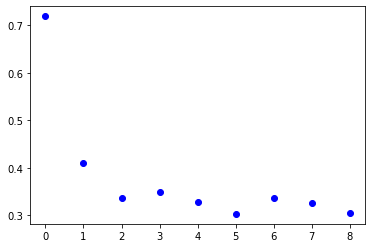

In [16]:
print('Evaluation parameters are: ', list(history.history.keys()))
evaluation_parameters = list(history.history.values())
loss = evaluation_parameters[0]
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo', label='Loss')
plt.show()

In [17]:
# Make predictions
def prediction_multiclass():
    random_bg = tf.random.uniform((), 0 , len_backgrounds, dtype=tf.int32)
    bg = backgrounds[random_bg]
    bg = resize_crop_img(bg)
    bg = bg.numpy()
    
    c_index = np.random.choice(range(3))
    choice = choices[c_index]
    if choice:
        obj = tf.io.read_file(os.path.join(choice))
        obj = tf.image.decode_jpeg(obj, channels=4)
        obj = tf.cast(obj, tf.float32) / 255.0
                    
        max_size = min(bg.shape[0], bg.shape[1])
        min_size = int(max_size/5)
        obj_size = tf.random.uniform((), min_size , max_size, dtype=tf.int32)
                    
        obj_max_index = tf.math.argmax((obj.shape[0], obj.shape[1]))
        resized_obj = tf.image.resize(obj, (obj_size, obj_size))
                    
        row0 = tf.random.uniform((), 0 , bg.shape[0] - obj_size, dtype=tf.int32)
        col0 = tf.random.uniform((), 0 , bg.shape[1] - obj_size, dtype=tf.int32)
        row1 = row0 + obj_size
        col1 = col0 + obj_size

        bg_slice1 = bg[row0:row1,col0:col1,:] # where we want to place `obj`
                    
        mask = (resized_obj[:,:,3] == 0) # find where the pokemon is 0
        mask = tf.cast(mask, tf.float32)
        bg_slice2 = np.expand_dims(mask, -1) * bg_slice1 # (h,w,1) x (h,w,3)
        obj_slice = np.expand_dims(np.logical_not(mask), -1)*resized_obj[:,:,:3]
        bg_slice = bg_slice2 + obj_slice
                    
        bg[row0:row1,col0:col1,:] = bg_slice
        
        classes = ["Apple", "Banana"]
        actual_class = classes[c_index]
        print("true:", int(row0), int(col0), int(row1), int(col1), actual_class)
    
  
    x = tf.image.resize(bg, (IMG_SIZE, IMG_SIZE))
    # Predict
    X = np.expand_dims(x, 0)
    p = model.predict(X)[0]

    # Plot
    fig, ax = plt.subplots(1)
    ax.imshow(x)
  
    # Draw the box
    if p[-1] > 0.5:
        row0 = int(p[0]*bg.shape[0])
        col0 = int(p[1]*bg.shape[1])
        row1 = int(row0 + p[2]*bg.shape[0])
        col1 = int(col0 + p[3]*bg.shape[1])
        class_pred_idx = np.argmax(p[4:6])
        class_pred = classes[class_pred_idx]
        print("pred:", row0, col0, row1, col1, class_pred)
        rect = Rectangle(
            (p[1]*IMG_SIZE, p[0]*IMG_SIZE),
            p[3]*IMG_SIZE, p[2]*IMG_SIZE,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    else:
        print("pred: no object")
    plt.show()

true: 7 11 206 210 Banana
pred: 6 10 199 209 Banana


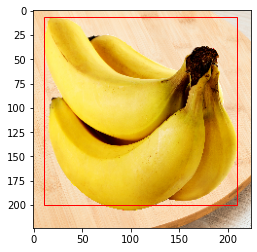

In [18]:
choices = [os.path.join(apple_dir,np.random.choice(apple_list)),
           os.path.join(banana_dir,np.random.choice(banana_list)),
           None]
prediction_multiclass()